In [73]:
# Set root directory to nearest parent folder for this file
import os
import sys

def git_root(current_dir=None):
    """Find root directory for a github repo above 'current_dir'.
    
    Args:
        current_dir: str. Path to directory within a git repo. 
            If None, defaults to the current working directory.
            
    Returns:
        Path to parent directory containing '.git'.
        
    Raises:
        ValueError: If no parent directory contains '.git'.
    """
    result = current_dir or os.getcwd()
    while True:
        if '.git' in os.listdir(result):
            return result
        if result == "/":
            raise ValueError("Could not find parent directory containing .git.")
        result = os.path.dirname(result)

def maybe_add_to_sys_path(path):
    """Add 'path' to 'sys.path' if it's not already there."""
    if path in sys.path:
        return
    sys.path.append(path)
    
maybe_add_to_sys_path(git_root())

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ipyleaflet
import json
import os
from duckworthd import mining
import ee; ee.Initialize()
import shapely

%matplotlib inline

In [70]:
# Load mining site masks.

mining_site_masks = gpd.read_file(os.path.expanduser("~/Desktop/datakind/qgis/mining_masks.shp"))
mining_site_masks = mining_site_masks.iloc[0:1]
mining_site_masks.head()

,pcode,geometry
0,codmine00064,"POLYGON ((29.05845782923338 1.148264452652914,..."


In [71]:
# Load IPIS mining site locations

mining_site_locations = gpd.read_file(os.path.expanduser(
    "~/Desktop/datakind/data/ipis_last_visit/cod_mines_curated_lastvisit_opendata_p_ipis.shp"))

# Select only mining site locations that have been labeled.
mining_site_locations = mining_site_locations[mining_site_locations.pcode.isin(mining_site_masks.pcode)]

# To keep plotting easy, make a small ball around each mining site location.
# mining_site_locations["geometry"] = mining_site_locations.geometry.buffer(1e-4)

mining_site_locations.head()

,vid,pcode,name,visit_date,longitude,latitude,province,province_o,territoire,collectivi,...,final_des1,armed_grou,frequency_,armed_gro0,frequency0,is_3t_mine,is_gold_mi,presence,interferen,geometry
62,1683.0,codmine00064,Mabukulu,2015-06-18,29.05885,1.14835,Ituri,Orientale,Mambasa,Babila-Bakwanza,...,None,FARDC,Une fois par mois,None,None,0,1,1,1.0,POINT (29.05885 1.14835)


In [72]:
# Visualize mining masks.

def get_center(geodataframe):
    """Get a point at the center of a geodataframe's geometry."""
    center = geodataframe.unary_union.convex_hull.centroid
    latitude = center.y
    longitude = center.x
    return (latitude, longitude)

def get_layer(geo_dataframe, color="blue", alpha=0.5):
    """Constructs a Layer based on a GeoDataFrame's geometry."""
    return ipyleaflet.GeoJSON(data=json.loads(geo_dataframe.to_json()), 
                              style={"color": color, "alpha": 0.5})

def satellite_tiles():
    """Constructs a TileLayer with using satellite imagery."""
    return ipyleaflet.TileLayer(
        url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}')

# Construct a map.
leaflet_map = ipyleaflet.Map(center=get_center(mining_site_masks), 
                             zoom=6, 
                             default_tiles=satellite_tiles())

# Add mining site locations and their accompanying masks.
leaflet_map.add_layer(get_layer(mining_site_locations, color="red", alpha=1.0))
leaflet_map.add_layer(get_layer(mining_site_masks, color="blue"))

# Add the ability to draw polygons?
def print_polygon(self, action, geo_json):
    print 'self:', self
    print 'action:', action
    print 'geo_json:', geo_json
    
draw_polygon = ipyleaflet.DrawControl(polygons={"shapeOptions": {}})
draw_polygon.on_draw(print_polygon)
leaflet_map.add_control(draw_polygon)

# Plot
leaflet_map

In [41]:
# Functions for converting between GeoDataFrame, GeoJSON, and Earth Engine.

def geodataframe_to_earth_engine(geodataframe):
    """Converts a GeoDataFrame to an EarthEngine FeatureCollection."""
    geojson_str = geodataframe.to_json()
    geojson = json.loads(geojson_str)
    return geojson_to_earthengine(geojson)


def geojson_to_earthengine(geojson):
    """Converts a GeoJSON dict to an Earth Engine type.
    
    Args:
        geojson: GeoJSON-supported object as a nested dict/list/tuple.
      
    Returns:
        A matching type that Earth Engine understands (e.g. ee.FeatureCollection, ee.Geometry.Point).
    """
    if isinstance(geojson, dict):
        if 'type' not in geojson:
            raise ValueError("Not 'type' attribute in geojson: %s" % (geojson,))
        if geojson['type'] == 'FeatureCollection':
            return earth_engine.FeatureCollection(
                geojson_to_earthengine(geojson['features']))
        elif geojson['type'] == 'Feature':
            return earth_engine.Feature(
                geojson_to_earthengine(geojson['geometry']),
                geojson['properties'])
        elif geojson['type'] == 'Point':
            return earth_engine.Geometry.Point(coords=geojson['coordinates'])
        elif geojson['type'] == 'Polygon':
            return earth_engine.Geometry.Polygon(
                coords=geojson['coordinates'],
                geodesic=geojson.get('geodesic', None))
        raise ValueError("Unsupported GeoJSON dict type: %s" % geojson['type'])
    elif isinstance(geojson, list):
        return [geojson_to_earthengine(element) for element in geojson]
    elif isinstance(geojson, tuple):
        return tuple(geojson_to_earthengine(element) for element in geojson)
    elif type(geojson) in [int, float, str, unicode]:
        return geojson
    else:
        raise ValueError("Unable to parse type: %s" % type(geojson))

In [88]:
# Construct a ee.Geometry.Polygon circle centered at a point.

def create_earth_engine_buffer(point_as_shapely, buffer_radius_in_meters):
    """Constructs a round ee.Geometry.Polygon around a shapely point."""
    point_as_geojson = shapely.geometry.mapping(point_as_shapely)
    point_as_earth_engine = earth_engine.Geometry(point_as_geojson)
    buffer_as_earth_engine = earth_engine.Geometry.buffer(
        point_as_earth_engine, buffer_radius_in_meters)
    return buffer_as_earth_engine

roi_buffer = create_earth_engine_buffer(
    mining_site_locations.iloc[0].geometry, 
    buffer_radius_in_meters=1500)
print roi_buffer

ee.Geometry({
  "type": "Invocation", 
  "arguments": {
    "geometry": {
      "type": "Point", 
      "coordinates": [
        29.05885, 
        1.14835
      ]
    }, 
    "distance": 1500
  }, 
  "functionName": "Geometry.buffer"
})


In [45]:
# Construct an earth_engine.Image mask with value 1.0 where mining_site_masks is defined.

def create_earth_engine_mask(geodataframe, key=None):
    """Construct ee.Image mask based on a GeoDataFrame's contents. """
    geodataframe = geodataframe.copy()
    if key is None:
        key = 'MASK_VALUE'
        geodataframe[key] = 1.0
    feature_collection_ee = geodataframe_to_earth_engine(geodataframe)
    image_ee = feature_collection_ee.reduceToImage(
        properties=[key],
        reducer=earth_engine.Reducer.first())
    return image_ee

mining_site_masks_ee = create_earth_engine_mask(mining_site_masks)
print mining_site_masks_ee

ee.Image({
  "type": "Invocation", 
  "arguments": {
    "reducer": {
      "type": "Invocation", 
      "arguments": {}, 
      "functionName": "Reducer.first"
    }, 
    "properties": [
      "MASK_VALUE"
    ], 
    "collection": {
      "type": "Invocation", 
      "arguments": {
        "features": [
          {
            "type": "Invocation", 
            "arguments": {
              "geometry": {
                "evenOdd": true, 
                "type": "Polygon", 
                "coordinates": [
                  [
                    [
                      29.058457829233383, 
                      1.1482644526529144
                    ], 
                    [
                      29.058457829233383, 
                      1.1487397156597572
                    ], 
                    [
                      29.059246924351683, 
                      1.1487397156597572
                    ], 
                    [
                      29.059246924351683, 
            

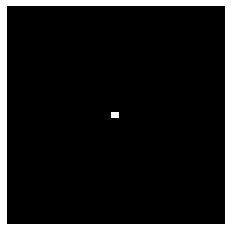

In [89]:
# Get rasterized mining site mask.

mask = mining.load_map_tile_containing_roi(mining_site_masks_ee, 
                                           roi_buffer.coordinates().getInfo(), 
                                           30)
mining.plot_image(mask[:, :, 0])